In [1]:
library(tidyverse)
library(repr)
library(caret)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



After installing tidyverse, repr, and caret, we needed to first load our datasets in via the git clone command in our terminal of juptyer:

git clone https://github.com/UBC-DSCI/datasets.git

In [2]:
install.packages('e1071')
library(e1071)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
#Our first step is to read our data through the read_csv() function, and 

kidney <- read_csv('datasets/chronic_kidney_disease/chronic_kidney_disease_full.csv') %>% 
    mutate(class = as.factor(class)) %>%
    #Removed NA values in our class column only
    filter(!is.na(class)) %>%
    mutate(wbcc = as.integer(wbcc))  #changed all scientific notation to integer

kidney_num <- kidney %>% 
    select(-sg, -al, -su, -rbc, -pc, -pcc, -ba, -htn, -dm, -cad, -appet, -pe, -ane)

kidney_scaled <- kidney_num %>% 
    select(-c(age, class)) %>% 
    scale(center = FALSE)

kidney_scaled <- data.frame(age = kidney$age, kidney_scaled, class = kidney$class)

    

#is.factor(kidney$class)

head(kidney_scaled)


Parsed with column specification:
cols(
  .default = col_character(),
  age = col_integer(),
  bp = col_integer(),
  sg = col_double(),
  al = col_integer(),
  su = col_integer(),
  bgr = col_integer(),
  bu = col_double(),
  sc = col_double(),
  sod = col_double(),
  pot = col_double(),
  hemo = col_double(),
  pcv = col_integer(),
  wbcc = col_double(),
  rbcc = col_double()
)
See spec(...) for full column specifications.


age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
48,1.0278113,0.7191124,0.4692584,0.1835944,NA,NA,1.1952734,1.1008365,0.8735420,1.0759119,ckd
7,0.6423821,NA,0.2346292,0.1223963,NA,NA,0.8770512,0.9507225,0.6719554,NA,ckd
62,1.0278113,2.5139220,0.6908526,0.2753916,NA,NA,0.7451055,0.7755894,0.8399443,NA,ckd
48,0.8993349,0.6953401,0.7299575,0.5813823,0.8035411,0.4432017,0.8692897,0.8006084,0.7503502,0.8069339,ckd
51,1.0278113,0.6299663,0.3389088,0.2141935,NA,NA,0.9003358,0.8756654,0.8175458,0.9517682,ckd
60,1.1562878,0.4397878,0.3258739,0.1682949,1.0279535,0.5672982,0.9469049,0.9757415,0.8735420,0.9103870,ckd


In [25]:
#  typeof(kidney_scaled$bu)


kidney_means <- kidney_scaled %>% 
    group_by(class) %>% 
    summarize_all(mean, na.rm = TRUE) #%>% 
#     t() %>% 
#     data.frame()
# colnames(kidney_means) <- c('ckd', 'notckd')
# kidney_means <- kidney_means[-1,]

#kidney_means$ckd <- as.numeric(kidney_means$ckd)
#kidney_means$notckd <- as.numeric(kidney_means$notckd)

kidney_means

# kidney_means <- kidney_means %>% 
#     mutate(difference = ckd - notckd)
# kidney_means


# kidney_sd <- kidney_num %>% 
#     select(-class) %>% 
#     summarize_all(sd, na.rm = TRUE)
is.factor(kidney_means$age)

class,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
ckd,54.42500,1.0240326,1.0431517,0.9470699,0.6778795,0.9691903,0.865667,0.8267734,0.8234158,1.0197419,0.8186862
notckd,46.32432,0.9168147,0.6402316,0.4261427,0.1330209,1.0258924,0.770063,1.1796961,1.1593293,0.8609232,1.1137961


[1] FALSE

In [5]:
?summarize

Warning message:
“Removed 113 rows containing missing values (geom_point).”

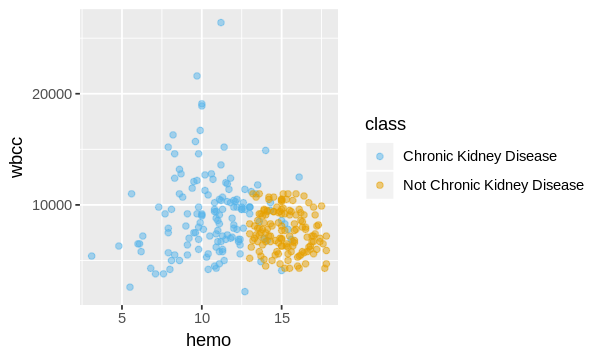

In [6]:
cbPalette <- c("#56B4E9", "#E69F00","#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")

options(repr.plot.height = 3, repr.plot.width = 5)

kidney_plot <- kidney %>% 
    ggplot(aes(x = hemo, y = wbcc, colour = class)) +
    geom_point(alpha = 0.5) +
    scale_color_manual(labels = c("Chronic Kidney Disease", "Not Chronic Kidney Disease"), values = cbPalette)

kidney_plot

In [7]:
set.seed(1234)

set_rows <- kidney %>% 
    select(class) %>% 
    unlist() %>% 
    createDataPartition(p = 0.75, list = FALSE) #CHECK TO SEE IF THIS IS RANDOMIZED

head(set_rows)

training_kidney <- kidney %>% slice(set_rows)
validation_kidney <- kidney %>% slice(-set_rows)

head(training_kidney)
tail(training_kidney)

Resample1
2
3
5
6
8
9


age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
7,50,1.020,4,0,NA,normal,notpresent,notpresent,NA,⋯,38,6000,NA,no,no,no,good,no,no,ckd
62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,⋯,31,7500,NA,no,yes,no,poor,no,yes,ckd
51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,⋯,35,7300,4.6,no,no,no,good,no,no,ckd
60,90,1.015,3,0,NA,NA,notpresent,notpresent,74,⋯,39,7800,4.4,yes,yes,no,good,yes,no,ckd
24,NA,1.015,2,4,normal,abnormal,notpresent,notpresent,410,⋯,44,6900,5.0,no,yes,no,good,yes,no,ckd
52,100,1.015,3,0,normal,abnormal,present,notpresent,138,⋯,33,9600,4.0,yes,yes,no,good,no,yes,ckd


age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
50,80,1.020,0,0,normal,normal,notpresent,notpresent,137,⋯,45,9500,4.6,no,no,no,good,no,no,notckd
55,80,1.020,0,0,normal,normal,notpresent,notpresent,140,⋯,47,6700,4.9,no,no,no,good,no,no,notckd
42,70,1.025,0,0,normal,normal,notpresent,notpresent,75,⋯,54,7800,6.2,no,no,no,good,no,no,notckd
12,80,1.020,0,0,normal,normal,notpresent,notpresent,100,⋯,49,6600,5.4,no,no,no,good,no,no,notckd
17,60,1.025,0,0,normal,normal,notpresent,notpresent,114,⋯,51,7200,5.9,no,no,no,good,no,no,notckd
58,80,1.025,0,0,normal,normal,notpresent,notpresent,131,⋯,53,6800,6.1,no,no,no,good,no,no,notckd


In [8]:
t_kidney_clean <- training_kidney %>% drop_na()

X_train <- t_kidney_clean %>% 
    select(hemo, wbcc) %>% 
    data.frame()

Y_train <- t_kidney_clean %>% 
    select(class) %>%  
    unlist()

k = data.frame(k = 3)

set.seed(1234)

#head(Y_train)
#tail(Y_train)

kidney_class <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k)

kidney_class

k-Nearest Neighbors 

120 samples
  2 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 120, 120, 120, 120, 120, 120, ... 
Resampling results:

  Accuracy   Kappa   
  0.7655672  0.339361

Tuning parameter 'k' was held constant at a value of 3

In [9]:
kidney_stats <- t_kidney_clean %>% 
    group_by(class) %>% 
    map_df(mean)

head(kidney_stats)
tail(t_kidney_clean)


Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.defaul

age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
49.04167,73.58333,1.020125,0.7666667,0.25,NA,NA,NA,NA,133.9333,⋯,42.43333,8550,4.841667,NA,NA,NA,NA,NA,NA,NA


age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
50,80,1.020,0,0,normal,normal,notpresent,notpresent,137,⋯,45,9500,4.6,no,no,no,good,no,no,notckd
55,80,1.020,0,0,normal,normal,notpresent,notpresent,140,⋯,47,6700,4.9,no,no,no,good,no,no,notckd
42,70,1.025,0,0,normal,normal,notpresent,notpresent,75,⋯,54,7800,6.2,no,no,no,good,no,no,notckd
12,80,1.020,0,0,normal,normal,notpresent,notpresent,100,⋯,49,6600,5.4,no,no,no,good,no,no,notckd
17,60,1.025,0,0,normal,normal,notpresent,notpresent,114,⋯,51,7200,5.9,no,no,no,good,no,no,notckd
58,80,1.025,0,0,normal,normal,notpresent,notpresent,131,⋯,53,6800,6.1,no,no,no,good,no,no,notckd
